In [1]:
# import data

import os

original_dir_path = '../data/shakespeare/original/'
modern_dir_path = '../data/shakespeare/modern/'

def read_all_files(dir_path):
    docs = ""
    for filename in os.listdir(dir_path):
        with open(dir_path + filename, 'r') as file:
            docs += file.read()
    return docs

original_docs = read_all_files(original_dir_path)
modern_docs = read_all_files(modern_dir_path)

print(original_docs[:100])
print(modern_docs[:100])

I have a mind to strike thee ere thou speak’st.
Yet if thou say Antony lives, is well, Or friends wi
I have half a mind to hit you before you speak again.
But if Antony is alive, healthy, friendly with


In [2]:
# One-hot encode entire dataset

from sklearn.preprocessing import LabelEncoder

dataset = (original_docs + " " + modern_docs).replace(".","").replace("\n", " ").split(" ")
print(dataset[:100])

enc = LabelEncoder()
enc.fit(dataset)
V = len(enc.classes_) #size of vocabulary

['I', 'have', 'a', 'mind', 'to', 'strike', 'thee', 'ere', 'thou', 'speak’st', 'Yet', 'if', 'thou', 'say', 'Antony', 'lives,', 'is', 'well,', 'Or', 'friends', 'with', 'Caesar,', 'or', 'not', 'captive', 'to', 'him,', 'I’ll', 'set', 'thee', 'in', 'a', 'shower', 'of', 'gold', 'and', 'hail', 'Rich', 'pearls', 'upon', 'thee', 'Madam,', 'he’s', 'well', 'Well', 'said', 'And', 'friends', 'with', 'Caesar', 'Th’', 'art', 'an', 'honest', 'man', 'Caesar', 'and', 'he', 'are', 'greater', 'friends', 'than', 'ever', 'Make', 'thee', 'a', 'fortune', 'from', 'me', 'But', 'yet,', 'madam—', 'I', 'do', 'not', 'like', '“But', 'yet”', 'It', 'does', 'allay', 'The', 'good', 'precedence', 'Fie', 'upon', '“But', 'yet”', '“But', 'yet”', 'is', 'as', 'a', 'jailer', 'to', 'bring', 'forth', 'Some', 'monstrous', 'malefactor']


In [133]:
import numpy as np

original_sentences = original_docs.replace('.',"").split('\n')
modern_sentences = modern_docs.replace('.',"").split('\n')

original_sentences = original_sentences
modern_sentences = modern_sentences

max_length = 30

X_org = []
for sentence in original_sentences:
    words = sentence.split(" ")
    try:
        words = words[:30]
    except:
        pass
    word_idx = np.array(enc.transform(words))
    
    arr = np.zeros(max_length)
    arr[:len(words)] = word_idx
    X_org.append(arr)
    
X_modern = []
for sentence in modern_sentences:
    words = sentence.split(" ")
    try:
        words = words[:30]
    except:
        pass
    word_idx = np.array(enc.transform(words))
    
    arr = np.zeros(max_length)
    arr[:len(words)] = word_idx
    X_modern.append(arr)

X_org = np.array(X_org)
X_mod = np.array(X_modern)

In [134]:
import pickle


X_dict = {'X_org': X_org, 'X_mod': X_mod}
pickle_path = '../models/X_shakespeare_ohe.pickle'

with open(pickle_path, 'wb') as f:
    pickle.dump(X_dict, f)

X_dict_loaded = None
with open(pickle_path, 'rb') as f:
    X_dict_loaded = pickle.load(f)

In [85]:
# Overfit Autoencoder

import tensorflow as tf

def dense(x, n1, n2, name):
    with tf.variable_scope(name, reuse=None):
        weights = tf.get_variable("weights", shape=[n1, n2], initializer=tf.random_normal_initializer(mean=0, stddev=0.01))
        bias = tf.get_variable("bias", shape=[n2], initializer=tf.constant_initializer(0.0))
        out = tf.add(tf.matmul(x, weights), bias, name='matmul')
        return out

input_dim = max_length
n_l1 = 100
n_l2 = 100
z_dim = 2

def encoder(x, reuse=False):
    if reuse:
        tf.get_variable_scope().reuse_variables()
    with tf.name_scope('Encoder'):
        e_dense_1 = tf.nn.relu(dense(x, input_dim, n_l1, 'e_dense_1'))
        e_dense_2 = tf.nn.relu(dense(e_dense_1, n_l1, n_l2, 'e_dense_2'))
        latent_variable = dense(e_dense_2, n_l2, z_dim, 'e_latent_variable')
        return latent_variable
    
def decoder(z, reuse=False):
    if reuse:
        tf.get_varaiable_scope().reuse_variables()
    with tf.name_scope('Decodr'):
        d_dense_1 = tf.nn.relu(dense(z, z_dim, n_l2, 'd_dense_1'))
        d_dense_2 = tf.nn.relu(dense(d_dense_1, n_l2, n_l1, 'd_dense_2'))
        output = dense(d_dense_2, n_l2, input_dim, 'd_output')
        return output

In [86]:
tf.reset_default_graph()

learning_rate = 0.01
beta1 = 0.9

x_input = tf.placeholder(tf.float32, [None, max_length])

encoder_output = encoder(x_input)
decoder_output = decoder(encoder_output)

loss = tf.reduce_mean(tf.square(decoder_output - x_input))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(loss)

In [87]:
init = tf.global_variables_initializer()
num_epochs = 10
X = X_org
batch_size = 100

step = 0
with tf.Session() as sess:
    sess.run(init)
    for i in range(num_epochs):
        num_batches = int(X.shape[0] / batch_size)
        for b in range(num_batches):
            batch_x = X[:(b + 1) * batch_size]
            sess.run(optimizer, feed_dict={x_input: batch_x})
            if i % 100 == 0:
                batch_loss = sess.run(loss, feed_dict={x_input: batch_x})
                print("Loss: {0}".format(batch_loss))

Loss: 10412233.0
Loss: 4148458.5
Loss: 4148045.25
Loss: 4146912.75
Loss: 4145893.5
Loss: 4147863.5
Loss: 4146901.0
Loss: 4146691.0
Loss: 4146446.25
Loss: 4146140.25


# LSTM Autoencoder

In [7]:
def lstm_encoder(x, lstm_units=2, reuse=False):
    if reuse:
        tf.get_variable_scope().reuse_variables()
    with tf.variable_scope('Encoder'):
        initializer = tf.contrib.layers.xavier_initializer()
        lstm_fw = tf.nn.rnn_cell.LSTMCell(lstm_units, initializer=initializer)

        outputs, state = tf.nn.dynamic_rnn(lstm_fw, x, dtype=tf.float32)
        return state

def lstm_decoder(x, z, lstm_units=2, reuse=False):
    if reuse:
        tf.get_variable_scope().reuse_variables()
    with tf.variable_scope('Decoder'):
        initializer = tf.contrib.layers.xavier_initializer()
        lstm_fw = tf.nn.rnn_cell.LSTMCell(lstm_units, initializer=initializer)
        
        zero_tensor = tf.zeros_like(x)
        outputs, state = tf.nn.dynamic_rnn(lstm_fw, zero_tensor, initial_state=z)
        return outputs

In [149]:
tf.reset_default_graph()

learning_rate = 0.01
beta1 = 0.9

x_input = tf.placeholder(tf.int32, [None, 30])
#embedding = tf.expand_dims(x_input, axis=2)
embedding = tf.one_hot(x_input, V)

encoder_output = lstm_encoder(embedding, lstm_units=V)
decoder_output = lstm_decoder(embedding, encoder_output, lstm_units=V)

loss = tf.reduce_mean(tf.square(decoder_output - embedding))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(loss)

(?, 30, 29309)


In [ ]:
init = tf.global_variables_initializer()
num_epochs = 1000
X = X_org
batch_size = 100

losses = []
step = 0
with tf.Session() as sess:
    sess.run(init)
    for i in range(num_epochs):
        num_batches = int(X.shape[0] / batch_size)
        for b in range(num_batches):
            batch_x = X[:(b + 1) * batch_size]
            sess.run(optimizer, feed_dict={x_input: batch_x})
            
            if b % 10 == 0:
                loss_i = sess.run(loss, feed_dict={x_input: X})
                print("Loss: {0}".format(loss_i))
                losses.append(loss_i)

# Char-Level LSTM Autoencoder

In [3]:
# import data

import os

original_dir_path = '../data/shakespeare/original/'
modern_dir_path = '../data/shakespeare/modern/'

def read_all_files(dir_path):
    docs = ""
    for filename in os.listdir(dir_path):
        with open(dir_path + filename, 'r') as file:
            docs += file.read()
    return docs

original_docs = read_all_files(original_dir_path)
modern_docs = read_all_files(modern_dir_path)

print(original_docs[:100])
print(modern_docs[:100])

I have a mind to strike thee ere thou speak’st.
Yet if thou say Antony lives, is well, Or friends wi
I have half a mind to hit you before you speak again.
But if Antony is alive, healthy, friendly with


In [4]:
# One-hot encode entire dataset

from sklearn.preprocessing import LabelEncoder

dataset = list((original_docs + " " + modern_docs).replace(".","").replace("\n", " "))
print(dataset[:100])

enc = LabelEncoder()
enc.fit(dataset)
V = len(enc.classes_) #size of vocabulary
print(V)

['I', ' ', 'h', 'a', 'v', 'e', ' ', 'a', ' ', 'm', 'i', 'n', 'd', ' ', 't', 'o', ' ', 's', 't', 'r', 'i', 'k', 'e', ' ', 't', 'h', 'e', 'e', ' ', 'e', 'r', 'e', ' ', 't', 'h', 'o', 'u', ' ', 's', 'p', 'e', 'a', 'k', '’', 's', 't', ' ', 'Y', 'e', 't', ' ', 'i', 'f', ' ', 't', 'h', 'o', 'u', ' ', 's', 'a', 'y', ' ', 'A', 'n', 't', 'o', 'n', 'y', ' ', 'l', 'i', 'v', 'e', 's', ',', ' ', 'i', 's', ' ', 'w', 'e', 'l', 'l', ',', ' ', 'O', 'r', ' ', 'f', 'r', 'i', 'e', 'n', 'd', 's', ' ', 'w', 'i', 't']
80


In [130]:
import numpy as np

def matrify_sentences(sentences, encoder, max_length=200):
    X = []
    for sentence in sentences:
        letters = list(sentence)
        try:
            letters = letters[:max_length]
        except:
            pass
        letters_idx = np.array(encoder.transform(letters))
        
        arr = np.full(max_length, -1)
        arr[:len(letters)] = letters_idx
        X.append(arr)
    
    return np.array(X)


original_sentences = original_docs.replace('.',"").split('\n')
modern_sentences = modern_docs.replace('.',"").split('\n')

X_org = matrify_sentences(original_sentences, enc)
X_mod = matrify_sentences(modern_sentences, enc)

/Users/jinpark/anaconda/lib/python3.5/site-packages/numpy/core/numeric.py:301: FutureWarning: in the future, full(200, -1) will return an array of dtype('int64')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)


In [188]:
import tensorflow as tf

tf.reset_default_graph()

learning_rate = 0.01
beta1 = 0.9
max_length = 20

x_input = tf.placeholder(tf.int32, [None, max_length])
#embedding = tf.expand_dims(x_input, axis=2)
embedding = tf.one_hot(x_input, V)

encoder_output = lstm_encoder(embedding, lstm_units=V)
decoder_output = lstm_decoder(embedding, encoder_output, lstm_units=V)

loss = tf.reduce_mean(tf.square(decoder_output - embedding))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(loss)

In [195]:
init = tf.global_variables_initializer()
num_epochs = 20
X = X_org[:,:max_length]
batch_size = 100
saved_model_path = '../models/lstm_ae/lstm_ae.ckpt'
checkpoint_dir = '../models/lstm_ae/'

saver = tf.train.Saver()
losses = []
step = 0
with tf.Session() as sess:
    try:
        saver.restore(sess, '../models/lstm_ae/lstm_ae.ckpt-84000')
    except:
        print('No model')
        sess.run(init)
        
    # Train
    
    for i in range(num_epochs):
        num_batches = int(X.shape[0] / batch_size)
        for b in range(num_batches):
            batch_x = X[b * batch_size:(b + 1) * batch_size]
            sess.run(optimizer, feed_dict={x_input: batch_x})
            
            if i % 2 == 0 and b == 0:
                loss_i = sess.run(loss, feed_dict={x_input: batch_x})
                print("Loss: {0}".format(loss_i))
                losses.append(loss_i)

                saver.save(sess, saved_model_path, global_step=step)
            step += batch_size

INFO:tensorflow:Restoring parameters from ../models/lstm_ae/lstm_ae.ckpt-84000
Loss: 0.005685206037014723


KeyboardInterrupt: 

In [197]:
# test AE
import numpy as np
samples = X[np.random.choice(X.shape[0], size=5)]
checkpoint_dir = '../models/lstm_ae/'
saved_model_path = '../models/lstm_ae/lstm_ae.ckpt'

def textify_samples(x):
    x[:,-1] = np.full(x.shape[0], -1)
    eos_idx = np.argmin(x, axis=1)
    x = [x[i,:eos_idx[i]] for i in range(x.shape[0])]

    x_text = [enc.inverse_transform(x[i].astype(int)) for i in range(len(x))]
    x_text = [''.join(list(text)) for text in x_text]
    return x_text

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint(checkpoint_dir))
    x_generated = sess.run(decoder_output, feed_dict={x_input: samples})
    x_generated = np.argmax(x_generated, axis=2)
    
    print(textify_samples(samples))
    print(textify_samples(x_generated))
#sess.run(decoder_output, feed

INFO:tensorflow:Restoring parameters from ../models/lstm_ae/lstm_ae.ckpt-0
['Pish!', 'So do all thoughts', 'By running fast', 'Tell him there’s a ', 'To who?']
['Pisthun caiii;;;;  ', 'So do  at thou loo ', 'By nonnit  aith   o', 'Tell hit theee   rt', 'To shou  connine,  ']


/Users/jinpark/anaconda/lib/python3.5/site-packages/numpy/core/numeric.py:301: FutureWarning: in the future, full(5, -1) will return an array of dtype('int64')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)


# LSTM Autoencoder with adversarial training

In [112]:
def leaky_relu(x, alpha=0.01):
    """Compute the leaky ReLU activation function.
    
    Inputs:
    - x: TensorFlow Tensor with arbitrary shape
    - alpha: leak parameter for leaky ReLU
    
    Returns:
    TensorFlow Tensor with the same shape as x
    """
    # TODO: implement leaky ReLU
    out = tf.maximum(tf.cast(0.0, dtype='float64'), tf.cast(x, dtype='float64'))
    out1 = tf.minimum(tf.cast(0.0, dtype='float64'), tf.cast(alpha * x, dtype='float64'))
    return tf.cast(out + out1, dtype='float32')

def discriminator(x, reuse=False):
    """Compute discriminator score for a batch of input images.
    
    Inputs:
    - x: TensorFlow Tensor of flattened input images, shape [batch_size, 784]
    
    Returns:
    TensorFlow Tensor with shape [batch_size, 1], containing the score 
    for an image being real for each input image.
    """
    if reuse:
        tf.get_variable_scope().reuse_variables()
    with tf.variable_scope("discriminator"):
        # TODO: implement architecture
        x = tf.layers.dense(x, 10)
        x = leaky_relu(x)
        x = tf.layers.dense(x, 10)
        x = leaky_relu(x)
        x = tf.layers.dense(x, 1)
        logits = x
        return logits
    
def lstm_discriminator(x, lstm_units=2, reuse=False):
    if reuse:
        tf.get_variable_scope().reuse_variables()
    with tf.variable_scope('discriminator'):
        initializer = tf.contrib.layers.xavier_initializer()
        lstm_fw = tf.nn.rnn_cell.LSTMCell(lstm_units, initializer=initializer)

        outputs, state = tf.nn.dynamic_rnn(lstm_fw, x, dtype=tf.float32)
        logits = tf.layers.dense(outputs, 1)
        return logits
    
def gan_loss(logits_real, logits_fake):
    """Compute the GAN loss.
    
    Inputs:
    - logits_real: Tensor, shape [batch_size, 1], output of discriminator
        Log probability that the image is real for each real image
    - logits_fake: Tensor, shape[batch_size, 1], output of discriminator
        Log probability that the image is real for each fake image
    
    Returns:
    - D_loss: discriminator loss scalar
    - G_loss: generator loss scalar
    """
    # TODO: compute D_loss and G_loss
    labels_real = tf.ones_like(logits_real)
    labels_fake = tf.zeros_like(logits_fake)
    logits_fake_inv = -logits_fake
    
    D_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=labels_real, logits=logits_real) +
                            tf.nn.sigmoid_cross_entropy_with_logits(labels=labels_fake, logits=logits_fake))
    
    G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=labels_real, logits=logits_fake))

    return D_loss, G_loss

def get_solvers(learning_rate=1e-3, beta1=0.5):
    """Create solvers for GAN training.
    
    Inputs:
    - learning_rate: learning rate to use for both solvers
    - beta1: beta1 parameter for both solvers (first moment decay)
    
    Returns:
    - D_solver: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    - G_solver: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    """
    D_solver = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1)
    G_solver = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1)
    return D_solver, G_solver

In [176]:
import tensorflow as tf

tf.reset_default_graph()

learning_rate = 0.01
beta1 = 0.9
max_length = 20

x_input = tf.placeholder(tf.int32, [None, None])
#embedding = tf.expand_dims(x_input, axis=2)
embedding = tf.one_hot(x_input, V)

encoder_output = lstm_encoder(embedding, lstm_units=V)
decoder_output = lstm_decoder(embedding, encoder_output, lstm_units=V)

with tf.variable_scope("") as scope:
    logits_real = lstm_discriminator(tf.random_normal(encoder_output))
    logits_fake = lstm_discriminator(encoder_output, reuse=True) # might need to predict instead (argmax)

D_solver, G_solver = get_solvers()
D_loss, G_loss = gan_loss(logits_real, logits_fake)

D_train_step = D_solver.minimize(D_loss)
G_train_step = G_solver.minimize(G_loss)

In [178]:
def textify_samples(x):
    x_text = []
    for sentence in x:
        minimum = np.min(sentence)
        if sentence == -1:
            eos_idx = np.argmin(sentence)
            x_text.append(sentence[:eos_idx])
        else:
            x_text.append(sentence)
    
    x_text = [enc.inverse_transform(x_text[i].astype(int)) for i in range(len(x))]
    x_text = [''.join(list(text)) for text in x_text]
    return x_text

In [184]:
init = tf.global_variables_initializer()
num_epochs = 1000
X = X_org[:,:max_length]
batch_size = 1000
saved_model_path = '../models/lstm_ae_wa/lstm_ae_wa.ckpt'
checkpoint_dir = '../models/lstm_ae_wa/'

saver = tf.train.Saver()
losses = []
step = 0
curriculum_size = 1
curriculum_error = 0.1
with tf.Session() as sess:
    #try:
        #saver.restore(sess, tf.train.latest_checkpoint(checkpoint_dir))
    #except:
        #print('No model')
    sess.run(init)
        
    # Train
    
    for i in range(num_epochs):
        num_batches = int(X.shape[0] / batch_size)
        for b in range(num_batches):
            batch_x = X[b * batch_size:(b + 1) * batch_size]
            batch_x = np.copy(batch_x)[:,:curriculum_size]
            
            sess.run([D_train_step, G_train_step], feed_dict={x_input: batch_x})
            #if b % 2 == 0:
                #b5 = b / 2
                #x_batch_gen = X[b5 * batch_size:(b5 + 1) * batch_size]
                #sess.run(G_train_step, feed_dict={x_input: x_batch_gen})
            
            if i % 4 == 0 and b == 0:
                D_loss_i, G_loss_i = sess.run([D_loss, G_loss], feed_dict={x_input: batch_x})
                print("D_loss: {0}, G_loss: {1}".format(D_loss_i, G_loss_i))
                losses.append((D_loss_i, G_loss_i))
                
                x_gen_i = sess.run(decoder_output, feed_dict={x_input: batch_x})
                x_gen_i = np.argmax(x_gen_i, axis=2)
                print(i)
                num_show = 10
                print(textify_samples(batch_x[:num_show]))
                print(textify_samples(x_gen_i[:num_show]))
                
                if abs(D_loss_i - G_loss_i) < curriculum_error:
                    #curriculum_size += 1
                    pass

                saver.save(sess, saved_model_path, global_step=step)
            step += batch_size

D_loss: 1.3801724910736084, G_loss: 0.6912965178489685
0
['I', 'Y', 'M', 'W', 'A', 'T', 'C', 'M', 'B', 'F']
['I', 'k', 'd', 'o', 'Æ', 'Y', 'Æ', 'd', 'R', 'e']
D_loss: 1.3460313081741333, G_loss: 0.6997629404067993
4
['I', 'Y', 'M', 'W', 'A', 'T', 'C', 'M', 'B', 'F']
['I', 'k', 'd', 'o', 'Æ', 'Y', 'Æ', 'd', 'R', '‘']
D_loss: 1.2840192317962646, G_loss: 0.7229973077774048
8
['I', 'Y', 'M', 'W', 'A', 'T', 'C', 'M', 'B', 'F']
['I', 'k', 'd', 'o', 'Æ', 'Y', 'Æ', 'd', 'R', '‘']
D_loss: 1.2166125774383545, G_loss: 0.7491743564605713
12
['I', 'Y', 'M', 'W', 'A', 'T', 'C', 'M', 'B', 'F']
['I', 'k', 'd', 'o', 'Æ', 'Y', 'Æ', 'd', 'R', '‘']
D_loss: 1.1366677284240723, G_loss: 0.7664138078689575
16
['I', 'Y', 'M', 'W', 'A', 'T', 'C', 'M', 'B', 'F']
['T', 'k', 'd', 'o', 'Æ', 'Y', 'Æ', 'd', 'R', '‘']
D_loss: 1.0826858282089233, G_loss: 0.7708127498626709
20
['I', 'Y', 'M', 'W', 'A', 'T', 'C', 'M', 'B', 'F']
['T', 'k', 'g', 'o', 'Æ', 'Y', 'Æ', 'g', 'R', '‘']
D_loss: 1.0534191131591797, G_loss: 0.77198

KeyboardInterrupt: 

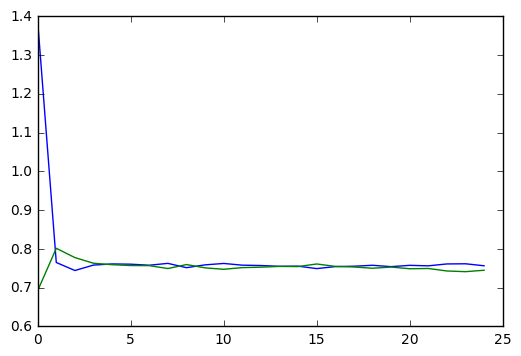

In [153]:
%matplotlib inline
import matplotlib.pyplot as plt

list_d_loss, list_g_loss = [], []
for d_loss, g_loss in losses:
    list_d_loss.append(d_loss)
    list_g_loss.append(g_loss)

plt.plot(list_d_loss)
plt.plot(list_g_loss)
plt.show()

In [187]:
lstm = tf.nn.rnn_cell.LSTMCell(2)
lstm.get_shape()

AttributeError: 'LSTMCell' object has no attribute 'get_shape'

# Adversarial LSTM Autoencoder

In [1]:
# import data

import os

original_dir_path = '../data/shakespeare/original/'
modern_dir_path = '../data/shakespeare/modern/'

def read_all_files(dir_path):
    docs = ""
    for filename in os.listdir(dir_path):
        with open(dir_path + filename, 'r') as file:
            docs += file.read()
    return docs

original_docs = read_all_files(original_dir_path)
modern_docs = read_all_files(modern_dir_path)

print(original_docs[:100])
print(modern_docs[:100])

I have a mind to strike thee ere thou speak’st.
Yet if thou say Antony lives, is well, Or friends wi
I have half a mind to hit you before you speak again.
But if Antony is alive, healthy, friendly with


In [2]:
# One-hot encode entire dataset

from sklearn.preprocessing import LabelEncoder

dataset = list((original_docs + " " + modern_docs).replace(".","").replace("\n", " "))
print(dataset[:100])

enc = LabelEncoder()
enc.fit(dataset)
V = len(enc.classes_) #size of vocabulary
print(V)

['I', ' ', 'h', 'a', 'v', 'e', ' ', 'a', ' ', 'm', 'i', 'n', 'd', ' ', 't', 'o', ' ', 's', 't', 'r', 'i', 'k', 'e', ' ', 't', 'h', 'e', 'e', ' ', 'e', 'r', 'e', ' ', 't', 'h', 'o', 'u', ' ', 's', 'p', 'e', 'a', 'k', '’', 's', 't', ' ', 'Y', 'e', 't', ' ', 'i', 'f', ' ', 't', 'h', 'o', 'u', ' ', 's', 'a', 'y', ' ', 'A', 'n', 't', 'o', 'n', 'y', ' ', 'l', 'i', 'v', 'e', 's', ',', ' ', 'i', 's', ' ', 'w', 'e', 'l', 'l', ',', ' ', 'O', 'r', ' ', 'f', 'r', 'i', 'e', 'n', 'd', 's', ' ', 'w', 'i', 't']
80


In [3]:
a = 'haisdfiasfhd'
list(a)

['h', 'a', 'i', 's', 'd', 'f', 'i', 'a', 's', 'f', 'h', 'd']

In [4]:
import numpy as np

def matrify_sentences(sentences, encoder, max_length=20):
    X = []
    for sentence in sentences:
        letters = list(sentence)
        try:
            letters = letters[:max_length]
        except:
            pass
        
        if letters:
            letters_idx = np.array(encoder.transform(letters))
        else:
            continue

        arr = np.full(max_length, -1)
        arr[:len(letters)] = letters_idx
        X.append(arr)
    
    return np.array(X)


original_sentences = original_docs.replace('.',"").split('\n')
modern_sentences = modern_docs.replace('.',"").split('\n')

X_org = matrify_sentences(original_sentences, enc)
X_mod = matrify_sentences(modern_sentences, enc)

In [5]:
def lstm_encoder(x, lstm_units=2, z_dim=10, reuse=False):
    if reuse:
        tf.get_variable_scope().reuse_variables()
    with tf.variable_scope('Encoder'):
        initializer = tf.contrib.layers.xavier_initializer()
        lstm_fw = tf.nn.rnn_cell.LSTMCell(lstm_units, initializer=initializer)

        outputs, state = tf.nn.dynamic_rnn(lstm_fw, x, dtype=tf.float32)
        c, h = state
        z = tf.add(tf.layers.dense(c, z_dim), tf.layers.dense(h, z_dim))
        return z

def lstm_decoder(x, z, lstm_units=2, reuse=False):
    if reuse:
        tf.get_variable_scope().reuse_variables()
    with tf.variable_scope('Decoder'):
        c = tf.layers.dense(z, lstm_units)
        h = tf.layers.dense(z, lstm_units)
        state = tf.nn.rnn_cell.LSTMStateTuple(c, h)
        
        initializer = tf.contrib.layers.xavier_initializer()
        lstm_fw = tf.nn.rnn_cell.LSTMCell(lstm_units, initializer=initializer)
        
        zero_tensor = tf.zeros_like(x)
        outputs, state = tf.nn.dynamic_rnn(lstm_fw, zero_tensor, initial_state=state)
        return outputs

def lstm_decoder_teacher_forced(x, z, lstm_units=2, training=True, reuse=False):
    if reuse:
        tf.get_variable_scope().reuse_variables()
    with tf.variable_scope('Decoder'):
        c = tf.layers.dense(z, lstm_units)
        h = tf.layers.dense(z, lstm_units)
        state = tf.nn.rnn_cell.LSTMStateTuple(c, h)
        
        initializer = tf.contrib.layers.xavier_initializer()
        lstm_fw = tf.nn.rnn_cell.LSTMCell(lstm_units, initializer=initializer)
        
        if training:
            go_vector = tf.fill([tf.shape(x)[0], tf.constant(1, dtype=int32)], -1)
            x_shifted_right = tf.stack([go_vector, x[:,:-1]]) 
            
            outputs, state = tf.nn.dynamic_rnn(lstm_fw, x_shifted_right, initial_state=state)
            return outputs
        else:
            input_tensor = tf.fill(tf.shape(x)[0], -1)
            outputs = []
            for _ in range(lstm_units):
                input_tensor, state = tf.nn.dynamic_rnn(lstm_fw, input_tensor, initial_state=state)
                outputs.append(input_tensor)
            return tf.stack(outputs, axis=1)

def leaky_relu(x, alpha=0.01):
    """Compute the leaky ReLU activation function.
    
    Inputs:
    - x: TensorFlow Tensor with arbitrary shape
    - alpha: leak parameter for leaky ReLU
    
    Returns:
    TensorFlow Tensor with the same shape as x
    """
    # TODO: implement leaky ReLU
    out = tf.maximum(tf.cast(0.0, dtype='float64'), tf.cast(x, dtype='float64'))
    out1 = tf.minimum(tf.cast(0.0, dtype='float64'), tf.cast(alpha * x, dtype='float64'))
    return tf.cast(out + out1, dtype='float32')

def discriminator(x, reuse=False):
    """Compute discriminator score for a batch of input images.
    
    Inputs:
    - x: TensorFlow Tensor of flattened input images, shape [batch_size, 784]
    
    Returns:
    TensorFlow Tensor with shape [batch_size, 1], containing the score 
    for an image being real for each input image.
    """
    if reuse:
        tf.get_variable_scope().reuse_variables()
    with tf.variable_scope("discriminator"):
        # TODO: implement architecture
        x = tf.layers.dense(x, 10)
        x = leaky_relu(x)
        x = tf.layers.dense(x, 10)
        x = leaky_relu(x)
        x = tf.layers.dense(x, 1)
        logits = x
        return logits
    
def lstm_discriminator(x, lstm_units=2, reuse=False):
    if reuse:
        tf.get_variable_scope().reuse_variables()
    with tf.variable_scope('discriminator'):
        initializer = tf.contrib.layers.xavier_initializer()
        lstm_fw = tf.nn.rnn_cell.LSTMCell(lstm_units, initializer=initializer)

        outputs, state = tf.nn.dynamic_rnn(lstm_fw, x, dtype=tf.float32)
        logits = tf.layers.dense(outputs, 1)
        return logits
    
def gan_loss(logits_real, logits_fake):
    """Compute the GAN loss.
    
    Inputs:
    - logits_real: Tensor, shape [batch_size, 1], output of discriminator
        Log probability that the image is real for each real image
    - logits_fake: Tensor, shape[batch_size, 1], output of discriminator
        Log probability that the image is real for each fake image
    
    Returns:
    - D_loss: discriminator loss scalar
    - G_loss: generator loss scalar
    """
    # TODO: compute D_loss and G_loss
    labels_real = tf.ones_like(logits_real)
    labels_fake = tf.zeros_like(logits_fake)
    logits_fake_inv = -logits_fake
    
    D_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=labels_real, logits=logits_real) +
                            tf.nn.sigmoid_cross_entropy_with_logits(labels=labels_fake, logits=logits_fake))
    
    G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=labels_real, logits=logits_fake))

    return D_loss, G_loss

def get_solvers(learning_rate=1e-3, beta1=0.5):
    """Create solvers for GAN training.
    
    Inputs:
    - learning_rate: learning rate to use for both solvers
    - beta1: beta1 parameter for both solvers (first moment decay)
    
    Returns:
    - D_solver: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    - G_solver: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    """
    D_solver = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1)
    G_solver = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1)
    return D_solver, G_solver

In [6]:
def lstm_decoder_teacher_forced(x, z, max_length, lstm_units=2, training=True, reuse=False, softmax=True):
    if reuse:
        tf.get_variable_scope().reuse_variables()
    with tf.variable_scope('Decoder', reuse=reuse):
        c = tf.layers.dense(z, lstm_units)
        h = tf.layers.dense(z, lstm_units)
        state = tf.nn.rnn_cell.LSTMStateTuple(c, h)
        
        initializer = tf.contrib.layers.xavier_initializer()
        lstm_fw = tf.nn.rnn_cell.LSTMCell(lstm_units, initializer=initializer)
        
        if training:
            with tf.name_scope('Training'):
                go_vector = tf.fill([tf.shape(x)[0], 1, lstm_units], 0)
                go_vector = tf.cast(go_vector, tf.float32)

                x_shifted_right = tf.concat([go_vector, x[:,:-1,:]], axis=1)

                outputs, state = tf.nn.dynamic_rnn(lstm_fw, x_shifted_right, initial_state=state)
                return outputs
        else:
            with tf.name_scope('Inference'):
                input_tensor = tf.fill([tf.shape(x)[0], 1, lstm_units], 0.0)
                outputs = []
                for i in range(max_length):
                    input_tensor, state = tf.nn.dynamic_rnn(lstm_fw, input_tensor, initial_state=state)
                    outputs.append(input_tensor)
                    
                    # use labels, not softmax
                    if not softmax:
                        input_tensor = tf.argmax(input_tensor, axis=2)
                        input_tensor = tf.one_hot(input_tensor, lstm_units, axis=2)
                return tf.concat(outputs, axis=1)

import tensorflow as tf

tf.reset_default_graph()

learning_rate = 0.01
beta1 = 0.9
max_length = 20
z_dim = 100
lambda_g = 0

x_input = tf.placeholder(tf.int32, [None, None])
embedding = tf.one_hot(x_input, V)

encoder_output = lstm_encoder(embedding, lstm_units=V, z_dim=z_dim)
with tf.variable_scope("") as scope:
    decoder_output = lstm_decoder_teacher_forced(embedding, encoder_output, max_length, lstm_units=V)
    decoder_output_inf = lstm_decoder_teacher_forced(embedding, encoder_output, max_length, training=False, reuse=True, lstm_units=V, softmax=False)

#with tf.variable_scope("") as scope:
    #logits_real = discriminator(tf.random_normal(tf.shape(encoder_output)))
    #logits_fake = discriminator(encoder_output, reuse=True) # might need to predict instead (argmax)
                                                                                                                                                                                                                              
_, G_solver = get_solvers()
#D_loss, G_loss = gan_loss(logits_real, logits_fake)
G_loss = tf.reduce_mean(tf.square(decoder_output - embedding))
G_loss_inf = tf.reduce_mean(tf.square(decoder_output_inf - embedding))

#G_loss = tf.reduce_mean(tf.square(decoder_output_inf - embedding)) + lambda_g * G_loss

#D_train_step = D_solver.minimize(D_loss)
G_train_step = G_solver.minimize(G_loss)

In [7]:
def textify_samples(x):
    x_text = []
    for sentence in x:
        minimum = np.min(sentence)
        if minimum == -1:
            eos_idx = np.argmin(sentence)
            x_text.append(sentence[:eos_idx])
        else:
            x_text.append(sentence)
    
    x_text = [enc.inverse_transform(x_text[i].astype(int)) for i in range(len(x))]
    x_text = [''.join(list(text)) for text in x_text]
    return x_text

In [8]:
init = tf.global_variables_initializer()
num_epochs = 1000
X = X_org[:,:max_length]
batch_size = 100
saved_model_path = '../models/lstm_ae_wa/lstm_ae_wa.ckpt'
checkpoint_dir = '../models/lstm_ae_wa/'

saver = tf.train.Saver()
losses = []
step = 0
curriculum_size = 20
curriculum_error = 0.2
with tf.Session() as sess:
    try:
        saver.restore(sess, tf.train.latest_checkpoint(checkpoint_dir))
    except:
        print('No model')
        sess.run(init)
        
    # Train
    
    for i in range(num_epochs):
        num_batches = int(X.shape[0] / batch_size)
        for b in range(num_batches):
            batch_x = X[b * batch_size:(b + 1) * batch_size]
            batch_x = np.copy(batch_x)[:,:curriculum_size]
            
            sess.run([G_train_step], feed_dict={x_input: batch_x})
            #if b % 2 == 0:
                #b5 = b / 2
                #x_batch_gen = X[b5 * batch_size:(b5 + 1) * batch_size]
                #sess.run(G_train_step, feed_dict={x_input: x_batch_gen})
            
            if i % 5 == 0 and b == 0:
                D_loss_i, G_loss_i = sess.run([G_loss, G_loss_inf], feed_dict={x_input: X})
                print("loss_train: {0}, loss_inf: {1}".format(D_loss_i, G_loss_i))
                losses.append((D_loss_i, G_loss_i))
                
                x_gen_i = sess.run(decoder_output, feed_dict={x_input: batch_x})
                x_gen_i = np.argmax(x_gen_i, axis=2)
                x_gen_i_inf = sess.run(decoder_output_inf, feed_dict={x_input: batch_x})
                x_gen_i_inf = np.argmax(x_gen_i_inf, axis=2)
                
                print(i)
                num_show = 5
                show_idx = np.random.choice(batch_x.shape[0], size=num_show)
                print(textify_samples(batch_x[show_idx]))
                print(textify_samples(x_gen_i[show_idx]))
                print(textify_samples(x_gen_i_inf[show_idx]))

                saver.save(sess, saved_model_path, global_step=step)
            step += batch_size

INFO:tensorflow:Restoring parameters from ../models/lstm_ae_wa/lstm_ae_wa.ckpt-2100000
loss_train: 0.0015865793684497476, loss_inf: 0.005917215254157782
0
['Rogue, thou hast liv', 'What mean you, madam', 'The gods confound th', 'Free, madam, no', 'Which do not be entr']
['Gouue, thou hast liv', 'What mean you, madam', 'The gods concound th', 'Free, madam, novvvvv', 'Whilh do not be entr']
['Godg, elit IashClea ', 'What mean you, madam', 'The gods concound lt', 'Free, madam, novitso', 'Whil ho It, oned r e']
loss_train: 0.0015558437444269657, loss_inf: 0.0057899500243365765
5
['Dost thou hold there', 'Though I am mad, I w', 'Tis no matter— Go to', 'Lead me from hence', 'I will not hurt him']
['Dost thou hold there', 'Though I am mad, I w', 'Tis no matter  Io to', 'Lead me mrom hence h', 'I will not hurt him ']
['Dost thou hold there', 'Though I am mad, I w', 'Tis no matter tom nt', 'Lead me mye celven d', 'I will not hurt him ']
loss_train: 0.0015514205442741513, loss_inf: 0.00576165877

loss_train: 0.0012787207961082458, loss_inf: 0.0045881615951657295
100
['Fie upon “But yet” “', 'Free, madam, no', 'Be pleased to tell u', 'Take no offense that', 'This ’greed upon To ']
['Fie unon bbut yetc c', 'Free, madam, novdvWW', 'Be wleased to tell u', 'Take no offense that', 'This ggreed uron Io ']
['Fie unovGut nout glo', 'Free, madam, novitas', 'Be welaces dr toe lh', 'Take no offense that', 'This goregde yat ofn']
loss_train: 0.0014091841876506805, loss_inf: 0.004882559180259705
105
['I’ll unhair thy head', 'I have made no fault', 'The merchandise whic', 'The man is innocent', 'Be attentive']
['I’ll hnhair thy head', 'I have made no fault', 'The merchandise whic', 'The man is innocento', 'Be attentive eeP’‘‘u']
['I’ll huanir th hidse', 'I have made no fault', 'The merchandise whic', 'The man is innocento', 'Be attentive eyog, l']
loss_train: 0.001215719268657267, loss_inf: 0.004574879072606564
110
['I have made no fault', 'At land indeed Thou ', 'I did not think, sir', 'Let 

KeyboardInterrupt: 

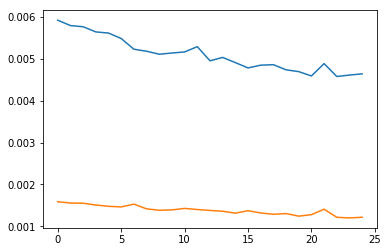

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

list_d_loss, list_g_loss = [], []
for d_loss, g_loss in losses:
    list_d_loss.append(d_loss)
    list_g_loss.append(g_loss)

#plt.plot(list_d_loss)
plt.plot(list_g_loss)
plt.plot(list_d_loss)
plt.show()

INFO:tensorflow:Restoring parameters from ../models/lstm_ae_wa/lstm_ae_wa.ckpt-2520000


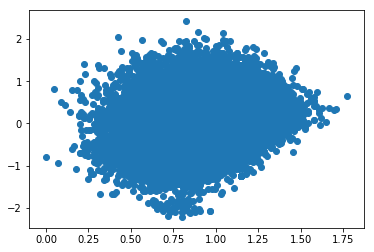

In [11]:
from sklearn.decomposition import TruncatedSVD

sess = tf.Session()
saver.restore(sess, tf.train.latest_checkpoint(checkpoint_dir))
latent_space = sess.run(encoder_output, feed_dict={x_input: X})
reducer = TruncatedSVD()
latent_space_2d = reducer.fit_transform(latent_space)
x_plot, y_plot = zip(*latent_space_2d)
plt.scatter(x_plot, y_plot)
plt.show()

In [12]:
import tensorflow as tf; print(tf.__version__)  # for Python 3

1.3.0


In [33]:
!which python

/Users/jinpark/anaconda/bin/python
